# Analyse semi-supervisée

## Chargement des données

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Chargement des features + labels forts
df_features = pd.read_parquet("../data/brain_features_resnet50.parquet")

# Données fortement labellisées (100 images)
df_strong = df_features[df_features["has_label"] == True].copy()
df_strong["target"] = df_strong["label_num"].astype(int)  # 0 normal, 1 cancer

# Données faiblement labellisées (pseudo-labels à partir de KMeans)
df_weak = pd.read_parquet("../data/brain_weak_labels_kmeans.parquet").copy()
df_weak.rename(columns={"weak_label_num": "target"}, inplace=True)
df_weak["target"] = df_weak["target"].astype(int)

print("Strongly labeled:", df_strong.shape)
print("Weakly labeled:", df_weak.shape)

df_strong.head(), df_weak.head()

Strongly labeled: (100, 2053)
Weakly labeled: (1406, 3)


(                                            filepath  has_label   label  \
 0  ..\data\mri_dataset_brain_cancer_oc\avec_label...       True  cancer   
 1  ..\data\mri_dataset_brain_cancer_oc\avec_label...       True  cancer   
 2  ..\data\mri_dataset_brain_cancer_oc\avec_label...       True  cancer   
 3  ..\data\mri_dataset_brain_cancer_oc\avec_label...       True  cancer   
 4  ..\data\mri_dataset_brain_cancer_oc\avec_label...       True  cancer   
 
         f_0       f_1       f_2       f_3       f_4       f_5       f_6  ...  \
 0  0.011641  0.014855  0.309468  0.112984  0.092031  0.000000  0.443308  ...   
 1  0.047576  0.045124  0.004747  0.000000  0.000000  0.000000  0.003254  ...   
 2  0.023101  0.067208  0.135242  0.000000  0.000000  0.000375  0.203493  ...   
 3  0.003039  0.192276  0.042327  0.000000  0.004168  0.000000  1.024806  ...   
 4  0.151541  0.046058  0.109404  0.000000  0.026315  0.008330  0.357026  ...   
 
      f_2040    f_2041    f_2042    f_2043    f_2044  

## Split train / test

In [5]:
train_strong, test_strong = train_test_split(
    df_strong,
    test_size=0.2,
    random_state=42,
    stratify=df_strong["target"]
)

print("Train fort:", train_strong.shape)
print("Test fort:", test_strong.shape)
train_strong["target"].value_counts(), test_strong["target"].value_counts()

Train fort: (80, 2053)
Test fort: (20, 2053)


(target
 0    40
 1    40
 Name: count, dtype: int64,
 target
 1    10
 0    10
 Name: count, dtype: int64)

## Dataset & DataLoader (images, pas features)

In [7]:
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Transforms d'entraînement / test (ImageNet)
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]),
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ]),
}

class MRICNNDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["filepath"]
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        label = int(row["target"])
        return img, label

### Dataloaders

In [9]:
batch_size = 16

train_strong_ds = MRICNNDataset(train_strong, transform=image_transforms["train"])
test_strong_ds  = MRICNNDataset(test_strong,  transform=image_transforms["test"])
weak_ds         = MRICNNDataset(df_weak,      transform=image_transforms["train"])

train_strong_loader = DataLoader(train_strong_ds, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader         = DataLoader(test_strong_ds,  batch_size=batch_size, shuffle=False, num_workers=0)
weak_loader         = DataLoader(weak_ds,         batch_size=batch_size, shuffle=True, num_workers=0)

len(train_strong_loader), len(test_loader), len(weak_loader)

(5, 2, 88)

## Modèle CNN : ResNet adapté à 2 classes

In [11]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def create_model(freeze_backbone=True):
    weights = ResNet50_Weights.IMAGENET1K_V2
    model = resnet50(weights=weights)

    # Remplacer la couche finale pour 2 classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 2)

    if freeze_backbone:
        for name, param in model.named_parameters():
            if not name.startswith("fc."):
                param.requires_grad = False

    return model.to(device)


Device: cpu


## Fonctions d'entrainement & d'évaluation

In [13]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0

    for imgs, labels in dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    return running_loss / len(dataloader.dataset)

def evaluate(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    return acc, f1, cm

##  Baseline : entrainement supervisé uniquement sur fortement labellisé

### EarlyStopping

In [16]:
import copy

class EarlyStopping:
    def __init__(self, patience=10, min_delta=1e-4, mode="max"):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.best = None
        self.counter = 0
        self.best_state = None

    def step(self, metric_value, model):
        if self.best is None:
            self.best = metric_value
            self.best_state = copy.deepcopy(model.state_dict())
            return False

        improved = (
            metric_value > self.best + self.min_delta
            if self.mode == "max"
            else metric_value < self.best - self.min_delta
        )

        if improved:
            self.best = metric_value
            self.counter = 0
            self.best_state = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1

        return self.counter >= self.patience

    def restore_best_weights(self, model):
        if self.best_state is not None:
            model.load_state_dict(self.best_state)


### Cration d'un val_loader

In [18]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

train_strong_sub, val_strong = train_test_split(
    train_strong,
    test_size=0.2,
    random_state=42,
    stratify=train_strong["target"]
)

train_strong_sub_ds = MRICNNDataset(train_strong_sub, transform=image_transforms["train"])
val_strong_ds = MRICNNDataset(val_strong, transform=image_transforms["test"])

train_strong_sub_loader = DataLoader(train_strong_sub_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_strong_ds, batch_size=batch_size, shuffle=False, num_workers=0)


### Fonction courbes d'apprentissage

In [20]:
import matplotlib.pyplot as plt

def plot_training_curves(history, title_prefix="Model"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_acc"], label="train")
    plt.plot(epochs, history["val_acc"], label="validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title_prefix} accuracy")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_loss"], label="train")
    plt.plot(epochs, history["val_loss"], label="validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title_prefix} loss")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [21]:
import matplotlib.pyplot as plt

def plot_learning_curves(history, title="Learning curves"):
    """
    history = dict contenant des listes :
      - train_loss, val_loss (optionnel), val_acc, val_f1
      - train_acc, train_f1 (optionnel)
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    # Loss
    plt.figure(figsize=(7,4))
    plt.plot(epochs, history["train_loss"], marker="o", label="train_loss")
    if "val_loss" in history:
        plt.plot(epochs, history["val_loss"], marker="o", label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # F1
    if "val_f1" in history:
        plt.figure(figsize=(7,4))
        plt.plot(epochs, history["val_f1"], marker="o", label="val_f1")
        if "train_f1" in history:
            plt.plot(epochs, history["train_f1"], marker="o", label="train_f1")
        plt.xlabel("Epoch")
        plt.ylabel("F1-score")
        plt.title(f"{title} - F1")
        plt.legend()
        plt.tight_layout()
        plt.show()

    # Accuracy
    if "val_acc" in history:
        plt.figure(figsize=(7,4))
        plt.plot(epochs, history["val_acc"], marker="o", label="val_acc")
        if "train_acc" in history:
            plt.plot(epochs, history["train_acc"], marker="o", label="train_acc")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.title(f"{title} - Accuracy")
        plt.legend()
        plt.tight_layout()
        plt.show()

In [22]:
import matplotlib.pyplot as plt

def plot_learning_curves_2panels(history, title="Training curves"):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_acc"], label="train")
    plt.plot(epochs, history["val_acc"], label="validation")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("model accuracy")
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_loss"], label="train")
    plt.plot(epochs, history["val_loss"], label="validation")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("model loss")
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [23]:
import torch
import torch.nn.functional as F

def evaluate_with_loss(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    n = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for imgs, labels, *_ in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            logits = model(imgs)
            loss = criterion(logits, labels)

            bs = imgs.size(0)
            total_loss += loss.item() * bs
            n += bs

            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_targets.append(labels.cpu())

    avg_loss = total_loss / max(n, 1)

    # réutilise ta logique de métriques (ici version simple)
    y_pred = torch.cat(all_preds).numpy()
    y_true = torch.cat(all_targets).numpy()

    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)

    return avg_loss, acc, f1, cm


### Baselinbe supervisée

[Baseline] Epoch 1/100 - train_loss=0.6675 - val_loss=0.6200 - val_acc=0.688 - val_f1=0.545
[Baseline] Epoch 2/100 - train_loss=0.5684 - val_loss=0.5683 - val_acc=0.688 - val_f1=0.545
[Baseline] Epoch 3/100 - train_loss=0.4854 - val_loss=0.5122 - val_acc=0.812 - val_f1=0.769
[Baseline] Epoch 4/100 - train_loss=0.4028 - val_loss=0.4630 - val_acc=0.875 - val_f1=0.857
[Baseline] Epoch 5/100 - train_loss=0.3618 - val_loss=0.4291 - val_acc=0.938 - val_f1=0.933
[Baseline] Epoch 6/100 - train_loss=0.3268 - val_loss=0.3989 - val_acc=0.938 - val_f1=0.933
[Baseline] Epoch 7/100 - train_loss=0.3568 - val_loss=0.3723 - val_acc=0.938 - val_f1=0.941
[Baseline] Epoch 8/100 - train_loss=0.2442 - val_loss=0.3602 - val_acc=0.938 - val_f1=0.941
[Baseline] Epoch 9/100 - train_loss=0.2509 - val_loss=0.3545 - val_acc=0.875 - val_f1=0.875
[Baseline] Epoch 10/100 - train_loss=0.2189 - val_loss=0.3330 - val_acc=0.938 - val_f1=0.941
[Baseline] Epoch 11/100 - train_loss=0.2161 - val_loss=0.3135 - val_acc=0.938 -

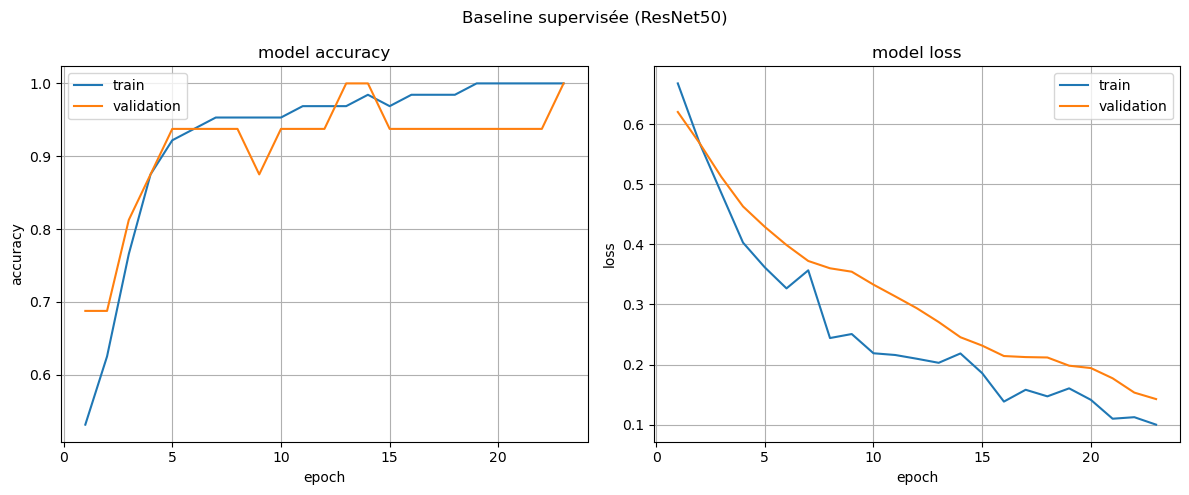

Baseline TEST
Loss: 0.3043500199913979
Accuracy: 0.9
F1-score: 0.9
Confusion matrix:
 [[9 1]
 [1 9]]


In [25]:
import torch.nn as nn
import torch.optim as optim

num_epochs = 100

baseline_model = create_model(freeze_backbone=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=1e-3)

early_stop = EarlyStopping(patience=10, mode="max")

history_baseline = {
    "train_loss": [],
    "train_acc": [],
    "train_f1": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1": []
}

for epoch in range(num_epochs):
    # 1) train step -> loss train
    train_loss = train_one_epoch(
        baseline_model, train_strong_sub_loader, optimizer, criterion, device
    )

    # 2) eval TRAIN (optionnel mais demandé pour courbes train vs val)
    train_eval_loss, train_acc, train_f1, _ = evaluate_with_loss(
        baseline_model, train_strong_sub_loader, criterion, device
    )

    # 3) eval VAL (avec loss)
    val_loss, val_acc, val_f1, _ = evaluate_with_loss(
        baseline_model, val_loader, criterion, device
    )

    # log history
    history_baseline["train_loss"].append(train_loss)
    history_baseline["train_acc"].append(train_acc)
    history_baseline["train_f1"].append(train_f1)

    history_baseline["val_loss"].append(val_loss)
    history_baseline["val_acc"].append(val_acc)
    history_baseline["val_f1"].append(val_f1)

    print(
        f"[Baseline] Epoch {epoch+1}/{num_epochs} "
        f"- train_loss={train_loss:.4f} "
        f"- val_loss={val_loss:.4f} "
        f"- val_acc={val_acc:.3f} - val_f1={val_f1:.3f}"
    )

    # early stopping sur val_f1 (comme toi)
    if early_stop.step(val_f1, baseline_model):
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Restaurer les meilleurs poids
early_stop.restore_best_weights(baseline_model)

# Plot style "mentor"
plot_learning_curves_2panels(
    history_baseline,
    title="Baseline supervisée (ResNet50)"
)

# Évaluation finale sur le TEST (UNE SEULE FOIS)
test_loss, baseline_acc, baseline_f1, baseline_cm = evaluate_with_loss(
    baseline_model, test_loader, criterion, device
)

print("Baseline TEST")
print("Loss:", test_loss)
print("Accuracy:", baseline_acc)
print("F1-score:", baseline_f1)
print("Confusion matrix:\n", baseline_cm)

## Semi-supervisé : faible puis fort

### Phase 1 : entrainement du jeu faible

[Semi phase 1 - weak] Epoch 1/100 - train_loss=0.3502 - val_loss=0.2493 - val_acc=0.938 - val_f1=0.933
[Semi phase 1 - weak] Epoch 2/100 - train_loss=0.1885 - val_loss=0.2180 - val_acc=0.938 - val_f1=0.933
[Semi phase 1 - weak] Epoch 3/100 - train_loss=0.1678 - val_loss=0.2338 - val_acc=0.938 - val_f1=0.933
[Semi phase 1 - weak] Epoch 4/100 - train_loss=0.1426 - val_loss=0.2355 - val_acc=0.938 - val_f1=0.933
[Semi phase 1 - weak] Epoch 5/100 - train_loss=0.1357 - val_loss=0.2951 - val_acc=0.938 - val_f1=0.933
[Semi phase 1 - weak] Epoch 6/100 - train_loss=0.1243 - val_loss=0.3091 - val_acc=0.938 - val_f1=0.933
[Semi phase 1 - weak] Epoch 7/100 - train_loss=0.1163 - val_loss=0.3709 - val_acc=0.938 - val_f1=0.933
[Semi phase 1 - weak] Epoch 8/100 - train_loss=0.0954 - val_loss=0.3578 - val_acc=0.938 - val_f1=0.933
[Semi phase 1 - weak] Epoch 9/100 - train_loss=0.0990 - val_loss=0.3552 - val_acc=0.938 - val_f1=0.933
[Semi phase 1 - weak] Epoch 10/100 - train_loss=0.0870 - val_loss=0.3292 

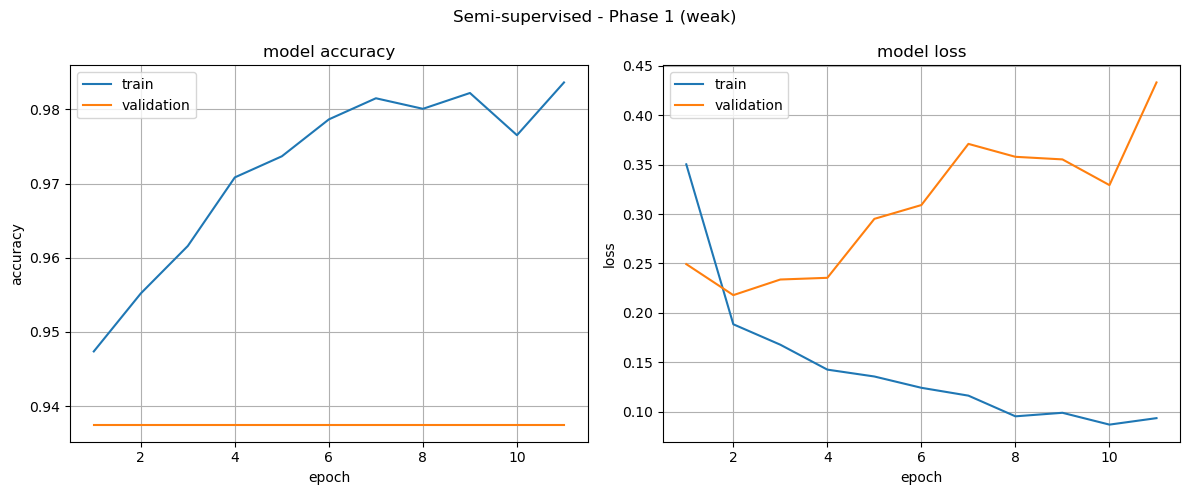

Semi-supervised TEST (after Phase 1 - weak)
Loss: 0.4214146614074707
Accuracy: 0.8
F1-score: 0.75
Confusion matrix:
 [[10  0]
 [ 4  6]]


In [28]:
import torch.nn as nn
import torch.optim as optim

# Phase 1 : entraînement sur le jeu faiblement labellisé
num_epochs_weak = 100

semi_model = create_model(freeze_backbone=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(semi_model.parameters(), lr=1e-3)

early_stop_weak = EarlyStopping(patience=10, mode="max")

history_weak = {
    "train_loss": [],
    "train_acc": [],
    "train_f1": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1": []
}

for epoch in range(num_epochs_weak):
    # 1) Train step
    train_loss = train_one_epoch(
        semi_model, weak_loader, optimizer, criterion, device
    )

    # 2) Eval TRAIN (pour avoir les courbes train vs val)
    train_eval_loss, train_acc, train_f1, _ = evaluate_with_loss(
        semi_model, weak_loader, criterion, device
    )

    # 3) Eval VAL (avec loss)
    val_loss, val_acc, val_f1, _ = evaluate_with_loss(
        semi_model, val_loader, criterion, device
    )

    # Historique
    # Option A (simple): on trace le train_loss venant de l'entraînement
    history_weak["train_loss"].append(train_loss)

    # Option B (plus comparable): décommente pour tracer train_eval_loss à la place
    # history_weak["train_loss"].append(train_eval_loss)

    history_weak["train_acc"].append(train_acc)
    history_weak["train_f1"].append(train_f1)

    history_weak["val_loss"].append(val_loss)
    history_weak["val_acc"].append(val_acc)
    history_weak["val_f1"].append(val_f1)

    print(
        f"[Semi phase 1 - weak] Epoch {epoch+1}/{num_epochs_weak} "
        f"- train_loss={train_loss:.4f} - val_loss={val_loss:.4f} "
        f"- val_acc={val_acc:.3f} - val_f1={val_f1:.3f}"
    )

    # Early stopping sur val_f1
    if early_stop_weak.step(val_f1, semi_model):
        print(f"Early stopping (weak) at epoch {epoch+1}")
        break

# Restaurer meilleurs poids
early_stop_weak.restore_best_weights(semi_model)

# Courbes format demandé
plot_learning_curves_2panels(history_weak, title="Semi-supervised - Phase 1 (weak)")

# Évaluation finale sur TEST (UNE SEULE FOIS)
test_loss, semi_acc, semi_f1, semi_cm = evaluate_with_loss(
    semi_model, test_loader, criterion, device
)

print("Semi-supervised TEST (after Phase 1 - weak)")
print("Loss:", test_loss)
print("Accuracy:", semi_acc)
print("F1-score:", semi_f1)
print("Confusion matrix:\n", semi_cm)

### Phase 2 : entrainement du jeu fort

[Semi phase 2 - strong] Epoch 1/100 - train_loss=0.3933 - val_loss=0.2093 - val_acc=0.938 - val_f1=0.933
[Semi phase 2 - strong] Epoch 2/100 - train_loss=0.3722 - val_loss=0.1779 - val_acc=0.938 - val_f1=0.933
[Semi phase 2 - strong] Epoch 3/100 - train_loss=0.4075 - val_loss=0.1644 - val_acc=0.938 - val_f1=0.933
[Semi phase 2 - strong] Epoch 4/100 - train_loss=0.3750 - val_loss=0.1590 - val_acc=0.938 - val_f1=0.933
[Semi phase 2 - strong] Epoch 5/100 - train_loss=0.3712 - val_loss=0.1543 - val_acc=0.938 - val_f1=0.933
[Semi phase 2 - strong] Epoch 6/100 - train_loss=0.2994 - val_loss=0.1486 - val_acc=0.938 - val_f1=0.933
[Semi phase 2 - strong] Epoch 7/100 - train_loss=0.2997 - val_loss=0.1517 - val_acc=0.938 - val_f1=0.933
[Semi phase 2 - strong] Epoch 8/100 - train_loss=0.2946 - val_loss=0.1466 - val_acc=0.938 - val_f1=0.933
[Semi phase 2 - strong] Epoch 9/100 - train_loss=0.3573 - val_loss=0.1416 - val_acc=0.938 - val_f1=0.933
[Semi phase 2 - strong] Epoch 10/100 - train_loss=0.291

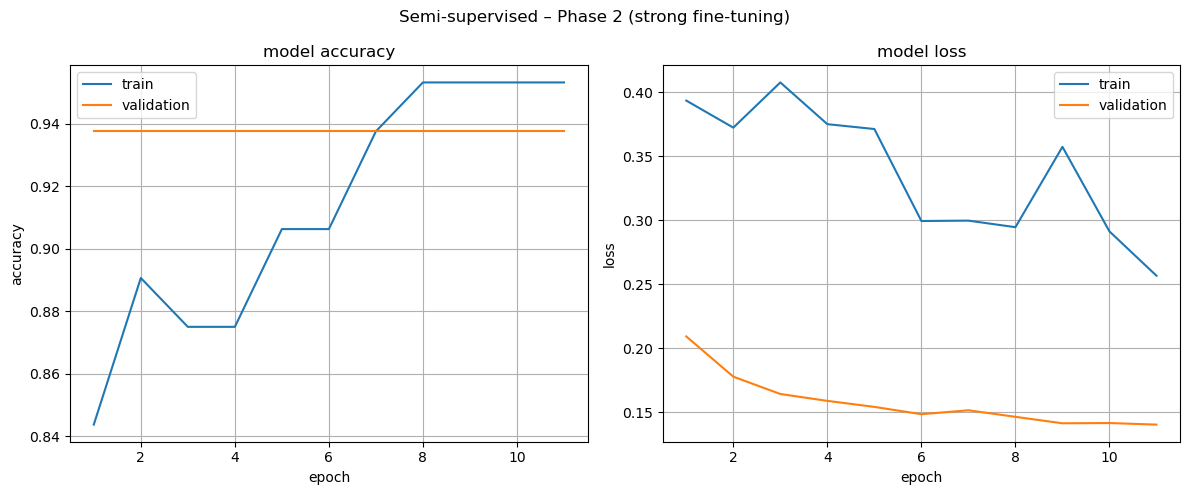

Semi-supervised TEST (after Phase 2 - strong)
Loss: 0.3763663053512573
Accuracy: 0.85
F1-score: 0.8235294117647058
Confusion matrix:
 [[10  0]
 [ 3  7]]


In [30]:
import torch.optim as optim
import torch.nn as nn

# --- Phase 2 : fine-tuning sur le jeu fortement labellisé ---
num_epochs_strong = 100

# On garde le MEME modèle semi_model (hérité de la phase weak)
criterion = nn.CrossEntropyLoss()

# Learning rate plus faible pour le fine-tuning
optimizer = optim.Adam(semi_model.parameters(), lr=5e-4)

early_stop_strong = EarlyStopping(patience=10, mode="max")

history_strong = {
    "train_loss": [],
    "train_acc": [],
    "train_f1": [],
    "val_loss": [],
    "val_acc": [],
    "val_f1": []
}

for epoch in range(num_epochs_strong):
    # 1) Train step sur le jeu fort (train)
    train_loss = train_one_epoch(
        semi_model,
        train_strong_sub_loader,
        optimizer,
        criterion,
        device
    )

    # 2) Eval TRAIN (pour courbes train vs val)
    train_eval_loss, train_acc, train_f1, _ = evaluate_with_loss(
        semi_model, train_strong_sub_loader, criterion, device
    )

    # 3) Eval VAL (avec loss)
    val_loss, val_acc, val_f1, _ = evaluate_with_loss(
        semi_model, val_loader, criterion, device
    )

    # Historique
    # Option A: train_loss venant de l'entraînement (rapide)
    history_strong["train_loss"].append(train_loss)

    # Option B: loss train "évaluée" (plus comparable à val_loss)
    # history_strong["train_loss"].append(train_eval_loss)

    history_strong["train_acc"].append(train_acc)
    history_strong["train_f1"].append(train_f1)

    history_strong["val_loss"].append(val_loss)
    history_strong["val_acc"].append(val_acc)
    history_strong["val_f1"].append(val_f1)

    print(
        f"[Semi phase 2 - strong] Epoch {epoch+1}/{num_epochs_strong} "
        f"- train_loss={train_loss:.4f} - val_loss={val_loss:.4f} "
        f"- val_acc={val_acc:.3f} - val_f1={val_f1:.3f}"
    )

    # Early stopping sur val_f1
    if early_stop_strong.step(val_f1, semi_model):
        print(f"Early stopping (strong) at epoch {epoch+1}")
        break

# Restaurer les meilleurs poids
early_stop_strong.restore_best_weights(semi_model)

# Courbes format demandé (2 panneaux)
plot_learning_curves_2panels(
    history_strong,
    title="Semi-supervised – Phase 2 (strong fine-tuning)"
)

# Évaluation finale sur le TEST (UNE SEULE FOIS)
test_loss, semi_acc, semi_f1, semi_cm = evaluate_with_loss(
    semi_model, test_loader, criterion, device
)

print("Semi-supervised TEST (after Phase 2 - strong)")
print("Loss:", test_loss)
print("Accuracy:", semi_acc)
print("F1-score:", semi_f1)
print("Confusion matrix:\n", semi_cm)

### Comparaison

| Modèle                         | Accuracy | F1-score |
| ------------------------------ | -------- | -------- |
| Baseline supervisée            | **0.90** | **0.90** |
| Semi-supervisé (weak → strong) | 0.85     | 0.82     |

Dans ce contexte de petit jeu de données annotées, l’apprentissage semi-supervisé permet de structurer l’espace de représentation mais ne dépasse pas un entraînement supervisé pur. Toutefois, il constitue une approche prometteuse et scalable lorsque l’annotation devient un facteur limitant.